# Tarea 2 - Kernels
## Librerías
Antes de comenzar, asegurarse que se tienen las siguentes librerías instaladas
se recomienda utilizar venv o virtualenv.

1. `pip install pillow`
2. `pip install matplotlib`
3. `pip install numpy`

## Instrucciones
En este ejercicio debes usar la imagen panda.png, la cual se encuentra en Canvas:
1. Transforma la imagen a tono de grises y trabaja con esta en los siguientes incisos. 
2. Investiga cómo se definen los filtros derivada (horizontal y vertical) Prewitt, Sobel y Scharr.
Aplica a la imagen de grises anterior los filtros Prewitt, Sobel y Scharr, para la detección de contornos.
Muestra cada una de las imágenes resultantes.

 NOTA: La implementación de estos kernels deben ser sin usar los métodos de algunas de las librerías.
Es decir, debes definirlos e implementarlas manualmente.    
 
3. Utiliza alguna de las librerías deseadas para implementar el método de Canny para la detección de bordes.
4. En este inciso deberás dibujar en la imagen a color panda.png, los vectores gradiente, ortogonales a los contornos de
la imagen de manera similar a como se muestra en el archivo 02_Fundamentos_y_Transformaciones.pdf, diapositiva 36.

Para calcular y aproximar el gradiente puedes utilizar cualquiera de los kernels derivada (Sobel, Prewitt o Scharr) que 
desees, para obtener las parciales con 𝑥 y con 𝑦. Además, para una mejor visualización de los vectores gradientes, 
puedes dibujar solamente un porcentaje de dichos vectores gradientes y solo aquellos que tengan las magnitudes más 
significativas. Asimismo, puedes estandarizar la magnitud de los vectores gradientes a un valor constante que desees.

### Import statements, Jupyter magicy definimos constantes

In [1]:
%matplotlib inline

In [2]:
from enum import Enum
from math import floor, sqrt
from PIL import Image

import matplotlib.pyplot as plt
import numpy as np

IMAGE_PATH = "resources/panda.png"

class PaddingMode(Enum):
    CEROS = "constant"
    REPLICA = "edge"
    SIMETRIA = "symmetric"
    CICLICO = "wrap"

### Funciones auxiliares

In [11]:
def apply_kernel(image, kernel):
    
    border_offset = floor(len(kernel) / 2)
    old_y_size, old_x_size = image.shape
    
    # The new image doesn't have a border and we need to account for the first and last row and columns (x2)
    new_image = np.zeros((old_y_size - (border_offset * 2), old_x_size - (border_offset * 2)), dtype=int)
    
    # Apply the kernel to each of the values
    # We need to start at the center of the kernel on the image, which is given by (boder_offset, border_offset)
    #  And end at the maximum size minus the border, with that, the output image will not have a border
    for y in range(border_offset, old_y_size - border_offset):
        for x in range(border_offset, old_x_size - border_offset):
            
            new_pixel = 0
            
            for (kernel_x, kernel_y), kernel_value in np.ndenumerate(kernel):
                old_value = image[y - border_offset + kernel_y,
                                  x - border_offset + kernel_x]
                new_pixel += old_value * kernel_value
            
            new_x = x - border_offset
            new_y = y - border_offset
            
            new_image[new_y, new_x] = new_pixel
    return new_image

def scale_pixel_values(image, low: int = 0, high: int = 255):
    min_value = np.amin(image)
    max_value = np.amax(image)
    
    image_scale_size = max_value - min_value
    reference_scale_size = high - low
    
    scale_factor = image_scale_size / reference_scale_size
    scale_factor = 1 if scale_factor == 0 else scale_factor # Avoiding dividing by zero
    
    # Use the size factor to divide all of the values in the image and floor them
    y_size, x_size = image.shape
    
    for y in range(y_size):
        for x in range(x_size):
            # First, we need to move the value to begin at the same point as low
            val = image[y][x]
            moved_val = val - min_value + low
            # Apply the floored scale factor
            image[y][x] = floor(moved_val / scale_factor)
    
    image = image.astype("int32")
    
    return image

def execute_operator(image, kernel, is_convolution: bool=False, padding_mode: PaddingMode = PaddingMode.CEROS):
    # We are assuming the kernel will be a square with a single center, i.e. size is of odd length
    if is_convolution:
        kernel = np.rot90(kernel, k=2)
    
    # Calculate the padding
    border_offset = floor(len(kernel) / 2)
    
    # Add padding to make sure the kernel is uniformly applied
    if padding_mode == PaddingMode.CEROS:
        image = np.pad(image, pad_width=border_offset, mode=PaddingMode.CEROS.value, constant_values=0)
    else:
        image = np.pad(image, pad_width=border_offset, mode=padding_mode.value)
    
    image = image.astype("int32")
    
    unscaled_new_image = apply_kernel(image, kernel)
    new_image = scale_pixel_values(unscaled_new_image, low=0, high=255)
                
    return new_image

def combine_gradients(gx, gy, strategy):
    y_len, x_len = gx.shape
    output = np.zeros((y_len, x_len))
    
    for y in range(y_len):
        for x in range(x_len):
            output[y][x] = strategy(gx[y][x], gy[y][x])
    
    output = scale_pixel_values(panda_sobel_final, low=0, high=255)
    return output
    

### 1. Cargar la imagen

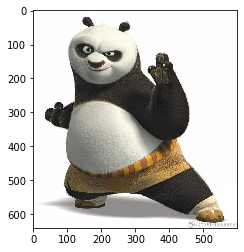

In [6]:
panda = Image.open(IMAGE_PATH)
plt.imshow(panda)

#### 1.1 Aplicamos un cambio a grises NTSC

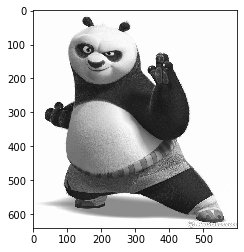

In [7]:
panda_grey_values = np.array(panda)

# Apply the greyscale by multiplying the R, G and B values of the image by the NTSC factors
panda_grey_values = np.floor(np.dot(panda_grey_values[...,:3], [0.2989, 0.5870, 0.1140]))
panda_grey_values = panda_grey_values.astype("int32")
panda_grey_image = Image.fromarray(panda_grey_values)

plt.imshow(panda_grey_image)

### 2.1. Aplicamos Prewitt

### 2.2. Aplicamos Sobel
#### 2.2.1 En Gx


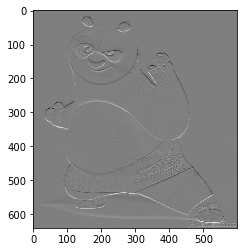

In [8]:
sobel_gx = [[1, 0, -1],
            [2, 0, -2],
            [1, 0, -1]]
            
panda_sobel_gx = execute_operator(panda_grey_image, sobel_gx, is_convolution = True)
plt.imshow(panda_sobel_gx, cmap = plt.cm.gray)

### 2.2.2 En Gy

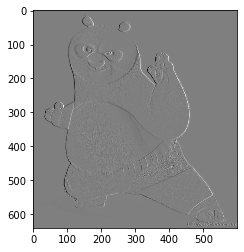

In [9]:
sobel_gy = [[1, 2, 1],
            [0, 0, 0],
            [-1, -2, -1]]

panda_sobel_gy = execute_operator(panda_grey_image, sobel_gy, is_convolution = True)
plt.imshow(panda_sobel_gy, cmap = plt.cm.gray)

### 2.2.3 Unificamos Gx con Gy

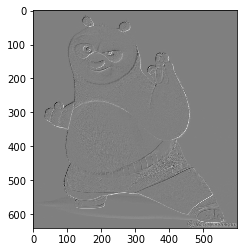

In [12]:
def sobel_combiner(x_elm, y_elm):
    return sqrt(x_elm**2 + y_elm**2)

panda_sobel_final = combine_gradients(panda_sobel_gx, panda_sobel_gy, sobel_combiner)
plt.imshow(panda_sobel_final, cmap = plt.cm.gray)

### 2.3. Aplicamos Scharr

### 3. Aplicamos Canny

### 4. Mostramos la gradiente en la imagen a color